# Gesture Recognition Project

In [1]:
# Importing necessary libraries
import numpy as np
import os
import cv2
import datetime
import os
import random as rn
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,ConvLSTM2D, GlobalAveragePooling2D,MaxPooling2D, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [2]:
# Train and validation document path
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())


In [3]:
# Custom function to crop image :

def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

## Generator

In [4]:
img_idx =range(0,30,2)
x = len(img_idx)

In [5]:
def generator(source_path, folder_list, batch_size,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
   
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # Cropping image by 10 % of original size cv2.:
                    #image = crop_img(image, 0.10)
    
                    # Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(y,z),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(y,z),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
                    #normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image by 10 % of original size :
                    #image = crop_img(image, 0.10)

                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(y,z),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(y,z),interpolation = cv2.INTER_AREA).astype(np.float32)

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


# MODEL 1: Image size: 120 * 120, batch size: 25, Epoch: 10

In [23]:
# model 1
y, z = 120, 120
input_shape = (x, y, z, 3)

model = Sequential()
model.add(Conv3D(8, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [24]:
# compiling the model
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 120, 120, 8)   656       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 60, 60, 8)     0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 60, 60, 16)     3472      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 30, 30, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 3, 30, 30, 32)     13856     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 15, 15, 32)   

In [25]:
# Generating data
batch_size = 25
num_epochs = 10

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [26]:
# Saving model and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [27]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [28]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 25
Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 1.5722 - categorical_accuracy: 0.2715Source path =  /datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2024-11-0415_11_40.587985/model-00001-1.57221-0.27149-1.59155-0.21000.h5
27/27 [==============================] - 26s 976ms/step - loss: 1.5722 - categorical_accuracy: 0.2715 - val_loss: 1.5915 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 1.5446 - categorical_accuracy: 0.2640
Epoch 00002: saving model to model_init_2024-11-0415_11_40.587985/model-00002-1.54463-0.26395-1.50472-0.22000.h5
27/27 [==============================] - 26s 979ms/step - loss: 1.5446 - categorical_accuracy: 0.2640 - val_loss: 1.5047 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 1.4726 - categorical_accuracy: 0.3

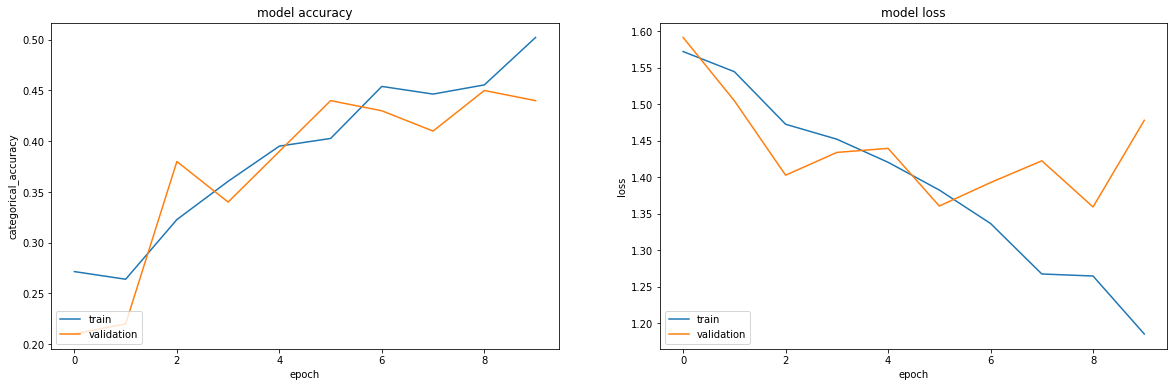

In [29]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result
### Training accuracy: 50% and Validation accuracy: 45%

# Model 2 : Image size: 120 * 120, batch size: 30, Epoch: 15

In [33]:
# Model 2
y, z = 120, 120
input_shape = (x, y, z, 3)

model = Sequential()
model.add(Conv3D(8, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [34]:
# compiling the model
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 15, 120, 120, 8)   656       
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 7, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 7, 60, 60, 16)     3472      
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 3, 30, 30, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 3, 30, 30, 32)     13856     
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 1, 15, 15, 32)   

In [35]:
# Generating data
batch_size = 30
num_epochs = 15

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [36]:
# Saving model and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [37]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [38]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.6070 - categorical_accuracy: 0.2549Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0415_11_40.587985/model-00001-1.60697-0.25490-1.57572-0.29000.h5
23/23 [==============================] - 27s 1s/step - loss: 1.6070 - categorical_accuracy: 0.2549 - val_loss: 1.5757 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.5351 - categorical_accuracy: 0.3092
Epoch 00002: saving model to model_init_2024-11-0415_11_40.587985/model-00002-1.53508-0.30920-1.48964-0.41000.h5
23/23 [==============================] - 25s 1s/step - loss: 1.5351 - categorical_accuracy: 0.3092 - val_loss: 1.4896 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/15
22/23 [===========================>..] - ETA: 0s - loss: 1.4893 - categorical_accuracy: 0.3636
Ep

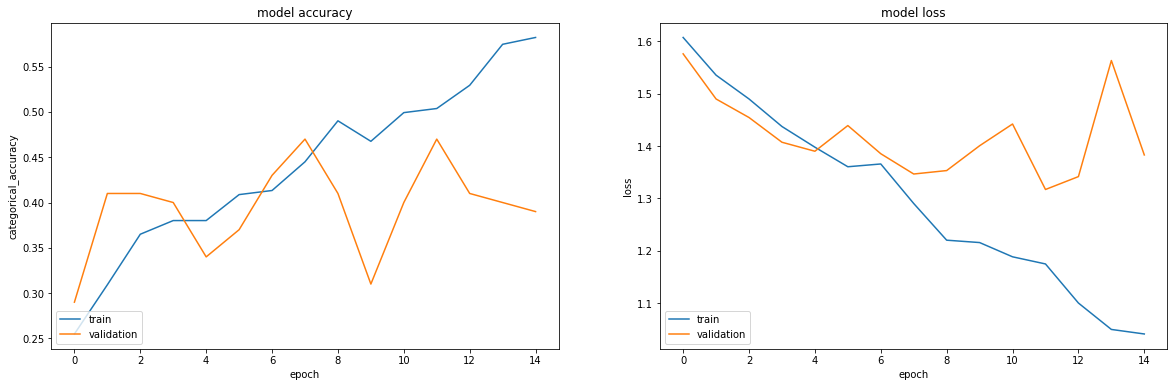

In [39]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result:
## Training accuracy: 58% and Validation accuracy:  39%. 
## Model overfitting

# MODEL 3: Image size: 120 * 120, batch size: 30, Epoch: 15 with BatchNormalisation

In [40]:
# Model 3
y, z = 120, 120
input_shape = (x, y, z, 3)

model = Sequential()
model.add(Conv3D(8, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv3D(16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv3D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [41]:
# compiling the model
optimiser = Adam(learning_rate=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 15, 120, 120, 8)   656       
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 7, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 7, 60, 60, 8)     32        
 ormalization)                                                   
                                                                 
 conv3d_22 (Conv3D)          (None, 7, 60, 60, 16)     3472      
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 3, 30, 30, 16)    0         
 g3D)                                                            
                                                      

In [43]:
# Generating data
batch_size = 30
num_epochs = 15

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [44]:
# Saving model and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [45]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [46]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 9.1641 - categorical_accuracy: 0.2142Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0415_11_40.587985/model-00001-9.16412-0.21418-90.66370-0.22000.h5
23/23 [==============================] - 30s 1s/step - loss: 9.1641 - categorical_accuracy: 0.2142 - val_loss: 90.6637 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 4.2264 - categorical_accuracy: 0.3092
Epoch 00002: saving model to model_init_2024-11-0415_11_40.587985/model-00002-4.22644-0.30920-5.40780-0.18000.h5
23/23 [==============================] - 29s 1s/step - loss: 4.2264 - categorical_accuracy: 0.3092 - val_loss: 5.4078 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/15
22/23 [===========================>..] - ETA: 1s - loss: 1.8256 - categorical_accuracy: 0.3303


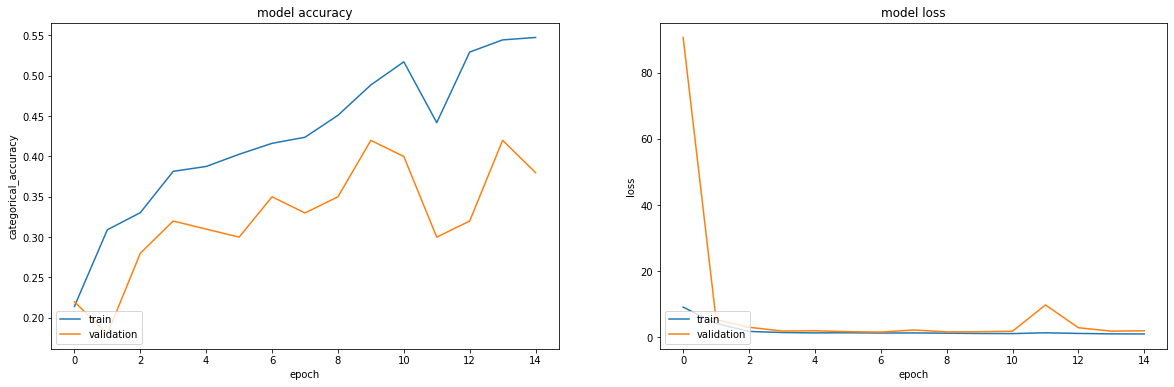

In [47]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result:
## Training accuracy: 55% and Validation accuracy:  38%
## Model still overfitting

# MODEL 4: Image size: 120 * 120, batch size: 30, Epoch: 15 with Batchnormalisation and dropouts

In [49]:
y, z = 120, 120
input_shape = (x, y, z, 3)

model = Sequential()
model.add(Conv3D(8, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv3D(16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))


In [50]:
# compiling the model
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_25 (Conv3D)          (None, 15, 120, 120, 8)   656       
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 7, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 7, 60, 60, 8)     32        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 7, 60, 60, 8)      0         
                                                                 
 conv3d_26 (Conv3D)          (None, 7, 60, 60, 16)     3472      
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 3, 30, 30, 16)   

In [51]:
# Generating data
batch_size = 30
num_epochs = 15

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [52]:
# Saving model and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [53]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [54]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 2.1679 - categorical_accuracy: 0.2926Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0415_11_40.587985/model-00001-2.16786-0.29261-1.64403-0.22000.h5
23/23 [==============================] - 31s 1s/step - loss: 2.1679 - categorical_accuracy: 0.2926 - val_loss: 1.6440 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
22/23 [===========================>..] - ETA: 1s - loss: 1.6682 - categorical_accuracy: 0.3576
Epoch 00002: saving model to model_init_2024-11-0415_11_40.587985/model-00002-1.66992-0.35596-1.65019-0.17000.h5
23/23 [==============================] - 28s 1s/step - loss: 1.6699 - categorical_accuracy: 0.3560 - val_loss: 1.6502 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/15
22/23 [===========================>..] - ETA: 1s - loss: 1.3840 - categorical_accuracy: 0.4591
Ep

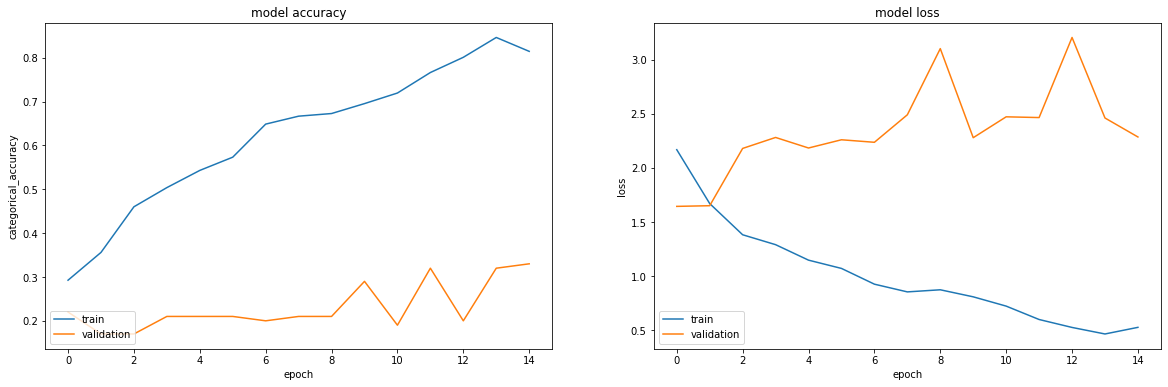

In [55]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result:
## Training accuracy: 80% and Validation accuracy: 30 %
## Model still overfitting, need augmentation

# MODEL 5: Image size: 120 * 120, batch size: 30, Epoch: 15. Increasing number of layers

In [56]:
y, z = 120, 120
input_shape = (x, y, z, 3)

model = Sequential()
model.add(Conv3D(16, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))


In [57]:
# compiling the model
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_29 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_30 (Conv3D)          (None, 7, 60, 60, 32)     13856     
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 3, 30, 30, 32)    128       
 hNormalization)                                                 
                                                      

In [58]:
# Generating data
batch_size = 30
num_epochs = 15

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [59]:
# Saving model and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [60]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [61]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.6299 - categorical_accuracy: 0.2926Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0415_11_40.587985/model-00001-1.62992-0.29261-1.60560-0.17000.h5
23/23 [==============================] - 30s 1s/step - loss: 1.6299 - categorical_accuracy: 0.2926 - val_loss: 1.6056 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.4857 - categorical_accuracy: 0.3394
Epoch 00002: saving model to model_init_2024-11-0415_11_40.587985/model-00002-1.48568-0.33937-1.60713-0.18000.h5
23/23 [==============================] - 25s 1s/step - loss: 1.4857 - categorical_accuracy: 0.3394 - val_loss: 1.6071 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
22/23 [===========================>..] - ETA: 0s - loss: 1.4650 - categorical_accuracy: 0.3742
Ep

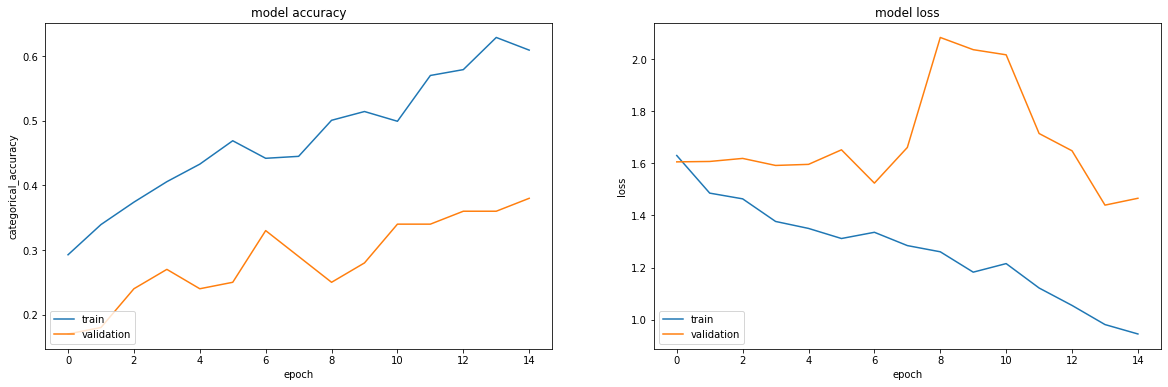

In [62]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result:
## Training accuracy: 61% and Validation accuracy:  38%
## Model is still not improving after trying many combinations

# MODEL 6: Image size: 120 * 120, batch size: 25, Epoch: 15 CNN-LSTM Model

In [82]:
y, z = 120, 120
input_shape = (x, y, z, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dense(128,activation='relu'))
model.add(Dense(5, activation='softmax'))

In [83]:
# compiling the model
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_47 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 15, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 15, 30, 30, 64) 

In [84]:
# Generating data
batch_size = 25
num_epochs = 15

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [85]:
# Saving model and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

callbacks_list = [checkpoint, LR]

In [86]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [87]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 25
Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 1.6070 - categorical_accuracy: 0.2278Source path =  /datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2024-11-0415_11_40.587985/model-00001-1.60696-0.22775-1.54136-0.37000.h5
27/27 [==============================] - 27s 961ms/step - loss: 1.6070 - categorical_accuracy: 0.2278 - val_loss: 1.5414 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 1.4560 - categorical_accuracy: 0.3605
Epoch 00002: saving model to model_init_2024-11-0415_11_40.587985/model-00002-1.45600-0.36048-1.45159-0.39000.h5
27/27 [==============================] - 25s 943ms/step - loss: 1.4560 - categorical_accuracy: 0.3605 - val_loss: 1.4516 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 1.3166 - categorical_accuracy: 0.4

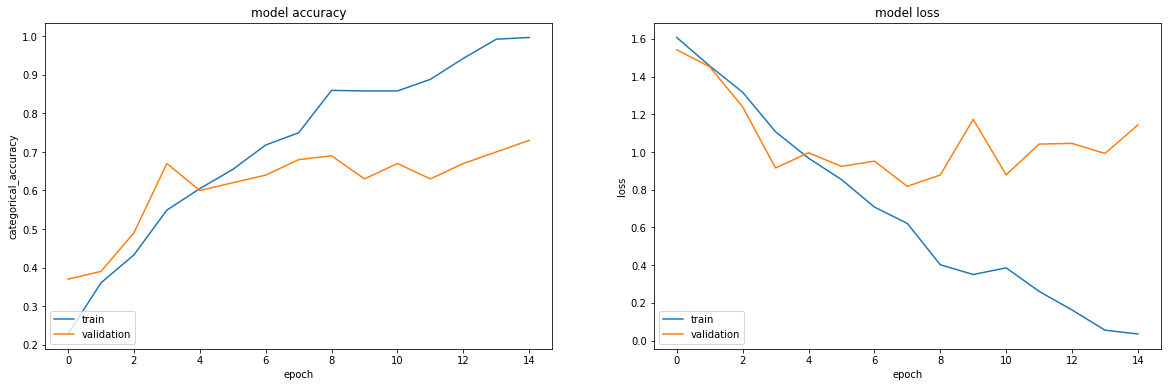

In [88]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result:
## Training accuracy: 100% and Validation accuracy:  73%

# MODEL 7: Image size: 120 * 120, batch size: 25, Epoch: 25 With increase number of layers

In [8]:
y, z = 120, 120
input_shape = (x, y, z, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(512))

model.add(Dense(512,activation='relu'))
model.add(Dense(5, activation='softmax'))

In [9]:
# compiling the model
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 30, 30, 64)  

In [10]:
# Generating data
batch_size = 25
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [11]:
# Saving model and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [12]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [13]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 25
Epoch 1/25


2024-11-04 17:26:56.498139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 1.6123 - categorical_accuracy: 0.1991Source path =  /datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2024-11-0417_26_00.688421/model-00001-1.61229-0.19910-1.60774-0.22000.h5
27/27 [==============================] - 30s 946ms/step - loss: 1.6123 - categorical_accuracy: 0.1991 - val_loss: 1.6077 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
27/27 [==============================] - ETA: 0s - loss: 1.6073 - categorical_accuracy: 0.2172
Epoch 00002: saving model to model_init_2024-11-0417_26_00.688421/model-00002-1.60730-0.21719-1.61088-0.20000.h5
27/27 [==============================] - 25s 942ms/step - loss: 1.6073 - categorical_accuracy: 0.2172 - val_loss: 1.6109 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
27/27 [==============================] - ETA: 0s - loss: 1.5949 - categorical_accuracy: 0.2232
Epoch 00003: saving model to model_init_2024-11-0417_26_00.688421/mod

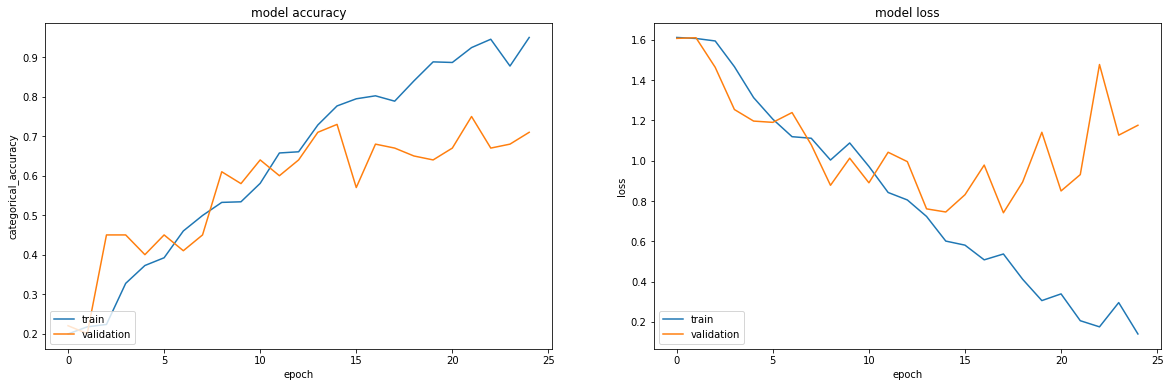

In [14]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result:
## Training accuracy: 92% and Validation accuracy:  75%

# MODEL 8: Image size: 160 * 160, batch size: 25, Epoch: 25

In [15]:
y, z = 160, 160
input_shape = (x, y, z, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(512))

model.add(Dense(512,activation='relu'))
model.add(Dense(5, activation='softmax'))

In [16]:
# compiling the model
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 15, 160, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 15, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 15, 80, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 40, 40, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 15, 40, 40, 64)  

In [17]:
# Generating data
batch_size = 25
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [18]:
# Saving model and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [19]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [20]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 25
Epoch 1/25
27/27 [==============================] - ETA: 0s - loss: 1.6218 - categorical_accuracy: 0.1961Source path =  /datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2024-11-0417_26_00.688421/model-00001-1.62179-0.19608-1.60594-0.18000.h5
27/27 [==============================] - 36s 1s/step - loss: 1.6218 - categorical_accuracy: 0.1961 - val_loss: 1.6059 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
27/27 [==============================] - ETA: 0s - loss: 1.5935 - categorical_accuracy: 0.2459
Epoch 00002: saving model to model_init_2024-11-0417_26_00.688421/model-00002-1.59355-0.24585-1.61709-0.20000.h5
27/27 [==============================] - 31s 1s/step - loss: 1.5935 - categorical_accuracy: 0.2459 - val_loss: 1.6171 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
27/27 [==============================] - ETA: 0s - loss: 1.6125 - categorical_accuracy: 0.1991
Ep

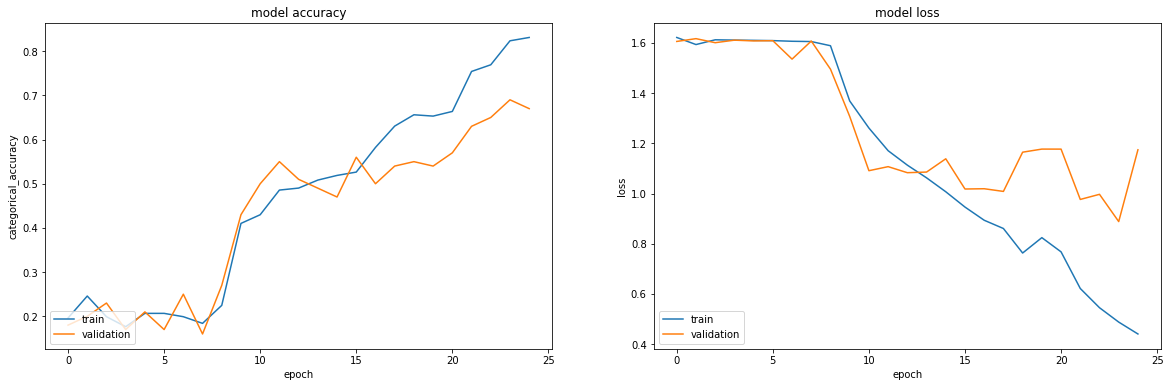

In [21]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result:
## Training accuracy: 83% and Validation accuracy:  69%

# MODEL 9: Image size: 120 * 120, batch size: 30, Epoch: 25 With GRU

In [22]:
y, z = 120, 120
input_shape = (x, y, z, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))
model.add(GRU(256))

model.add(Dense(256,activation='relu'))
model.add(Dense(5, activation='softmax'))

In [23]:
# compiling the model
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 15, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 15, 30, 30, 64)  

In [24]:
# Generating data
batch_size = 30
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [25]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [26]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.6193 - categorical_accuracy: 0.2217Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0417_26_00.688421/model-00001-1.61931-0.22172-1.60343-0.18000.h5
23/23 [==============================] - 28s 1s/step - loss: 1.6193 - categorical_accuracy: 0.2217 - val_loss: 1.6034 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
22/23 [===========================>..] - ETA: 0s - loss: 1.5493 - categorical_accuracy: 0.2621
Epoch 00002: saving model to model_init_2024-11-0417_26_00.688421/model-00002-1.54904-0.26094-1.39663-0.40000.h5
23/23 [==============================] - 25s 1s/step - loss: 1.5490 - categorical_accuracy: 0.2609 - val_loss: 1.3966 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/25
22/23 [===========================>..] - ETA: 0s - loss: 1.3729 - categorical_accuracy: 0.3727
Ep

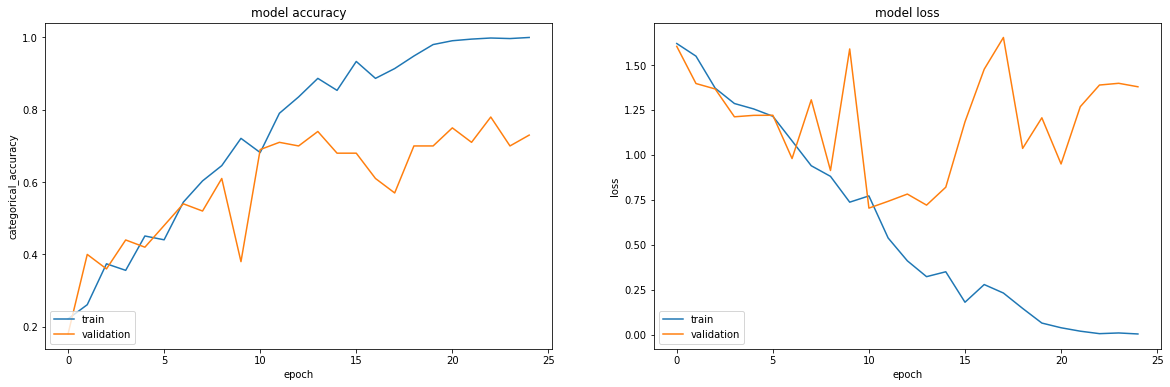

In [27]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result:
## Training accuracy: 100% and Validation accuracy:  78%

# MODEL 10: Image size: 120 * 120, batch size: 30, Epoch: 35 with BatchNormalisation

In [28]:
y, z = 120, 120
input_shape = (x, y, z, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))
model.add(GRU(256))

model.add(Dense(256,activation='relu'))
model.add(Dense(5, activation='softmax'))

In [29]:
# compiling the model
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_50 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 15, 60, 60, 32)  

In [30]:
# Generating data
batch_size = 30
num_epochs = 35

train_generator = generator(train_path, train_doc, batch_size,y,z)
val_generator = generator(val_path, val_doc, batch_size,y,z)

In [31]:
# Saving model and callbacks
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [32]:
# Calculating steps per epoch and validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [33]:
# Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/35
22/23 [===========================>..] - ETA: 0s - loss: 1.3397 - categorical_accuracy: 0.4591Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0417_26_00.688421/model-00001-1.34202-0.45701-1.98578-0.24000.h5
23/23 [==============================] - 28s 1s/step - loss: 1.3420 - categorical_accuracy: 0.4570 - val_loss: 1.9858 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/35
22/23 [===========================>..] - ETA: 0s - loss: 0.8519 - categorical_accuracy: 0.6530
Epoch 00002: saving model to model_init_2024-11-0417_26_00.688421/model-00002-0.85106-0.65309-2.60427-0.23000.h5
23/23 [==============================] - 26s 1s/step - loss: 0.8511 - categorical_accuracy: 0.6531 - val_loss: 2.6043 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/35
22/23 [===========================>..] - ETA: 0s - loss: 0.6066 - categorical_accuracy: 0.7636
Ep

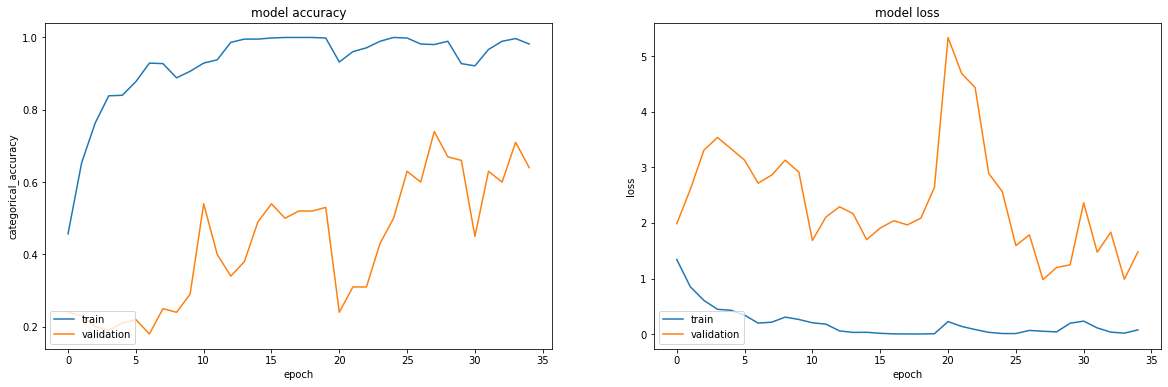

In [34]:
# Plotting the result of Model :

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['categorical_accuracy'])
ax1 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['loss'])
ax2 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.show()

# Result:
## Training accuracy: 98% and Validation accuracy:  74%